In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy.signal import savgol_filter
import random

# mapping '/' to __truediv__()
from __future__ import division 

from sklearn.metrics import mean_absolute_error
# possible alternative to above:
# tf.metrics.MeanAbsoluteError()

# helper code
from WindowGenerator import WindowGenerator
from Baseline import Baseline

mpl.rcParams['figure.figsize'] = (12, 3)
mpl.rcParams['axes.grid'] = False

VERBOSE = True
MAX_EPOCHS = 30
INPUT_WIDTH = 3
SHIFT = 8
LABEL_WIDTH = 1
WINDOW_SIZE = INPUT_WIDTH + SHIFT

if VERBOSE:
    print('Setup Complete')

Setup Complete


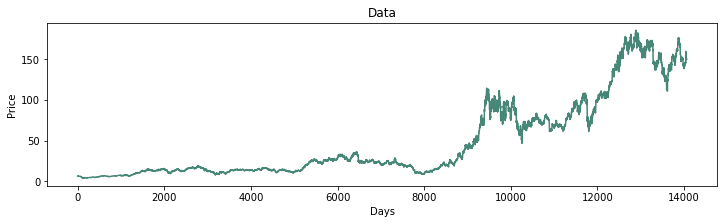

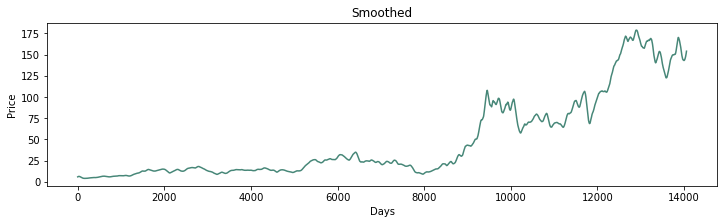

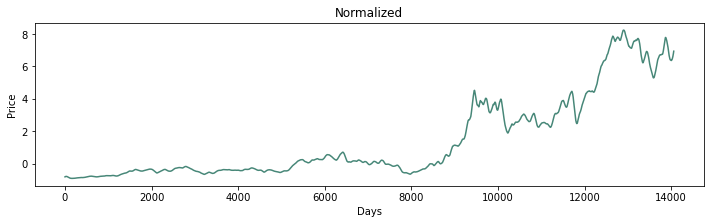

0       1962-01-02
1       1962-01-03
2       1962-01-04
3       1962-01-05
4       1962-01-08
           ...    
14054   2017-11-06
14055   2017-11-07
14056   2017-11-08
14057   2017-11-09
14058   2017-11-10
Name: ds, Length: 14059, dtype: datetime64[ns]
total samples = 14059
----------------------------------------
train_df samples = 9841
val_df samples = 2812
test_df samples = 1406
----------------------------------------
train + val + test = 14059


In [3]:
df = pd.read_csv('data/ibm_edit.csv')
# print(df)

# throw out some data
# df = df.drop(index=range(0, 9000))
# df = df.set_index(np.arange(0,len(df['y'])))
# print(df)

# seperate date_time
date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
# timestamp doesn't work if data is before 1970
if (date_time[0].year >= 1970):
    timestamp_s = date_time.map(datetime.datetime.timestamp)

plt.title('Data')
y = df['y']
x = np.arange( 0, len(y), 1 )
plt.ylabel('Price')
p1, = plt.plot( x, y, color='#478778' )
plt.xlabel('Days')
plt.show()

# smooth data
df['y'] = savgol_filter(df['y'], 155, 3) # window size, polynomial order

plt.title('Smoothed')
y = df['y']
x = np.arange( 0, len(y), 1 )
plt.ylabel('Price')
p1, = plt.plot( x, y, color='#478778' )
plt.xlabel('Days')
plt.show()

# split
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# normalize
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

plt.title('Normalized')
df_std = (df - train_mean) / train_std
y = df_std['y']
x = np.arange( 0, len(y), 1 )
plt.ylabel('Price')
p1, = plt.plot( x, y, color='#478778' )
plt.xlabel('Days')
plt.show()

if VERBOSE:
    print( date_time )
    print( "total samples = {0:d}".format( n ) )
    print( "----------------------------------------" )
    print( "train_df samples = {0:d}".format( len( train_df ) ) )
    print( "val_df samples = {0:d}".format( len( val_df ) ) )
    print( "test_df samples = {0:d}".format( len( test_df ) ) )
    print( "----------------------------------------" )
    print( "train + val + test = {0:d}".format( len( train_df ) + len( val_df ) + len( test_df ) ) )

frequencies: 1001
years: 7.968127490039841
[  0.       0.1255   0.251  ... 125.249  125.3745 125.5   ]


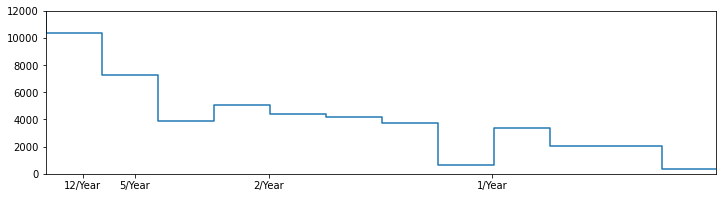

In [4]:
# frequency
fft = tf.signal.rfft(df['y'][10000:12000])

f_per_dataset = np.arange(0, len(fft))
n_samples_d = len(df['y'][10000:12000])
busi_days_per_year = 251 # less than business days but close to correct # of years
years_per_dataset = n_samples_d/(busi_days_per_year)
f_per_year = f_per_dataset/years_per_dataset

if VERBOSE:
    print(f'frequencies: {len(fft)}') # data_length / 2 + 1
    print(f'years: {years_per_dataset}')
    print(f_per_year)

plt.step(f_per_year, np.abs(fft))
plt.ylim(0, 12000)
plt.xlim([0.001, 1.5])
plt.xticks([0.083, 0.2, 0.5, 1], labels=['12/Year', '5/Year', '2/Year', '1/Year']) # f = 1/#years
plt.show()

In [457]:
conv_window = WindowGenerator( train_df=train_df, test_df=test_df, val_df=val_df,
                               input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=SHIFT, label_columns=['y'])
if VERBOSE:
    print( conv_window )

Total window size: 11
Input indices: [0 1 2]
Label indices: [10]
Label column name(s): ['y']


In [458]:
def compile_and_fit(model, window, patience=10):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val, callbacks=[early_stopping])
    
    return history

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(INPUT_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),])

test mean absolute error = 0.071


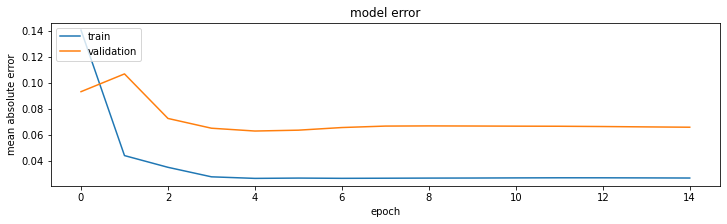

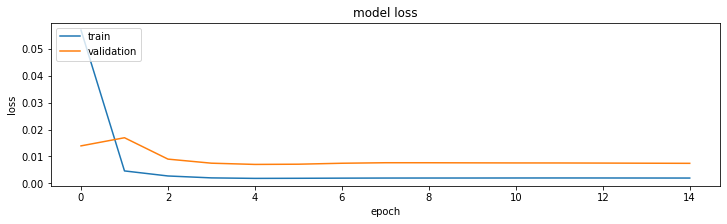

In [459]:
# train and eval model
history = compile_and_fit(conv_model, conv_window)
IPython.display.clear_output()

# use model on test
test_iterator = iter(conv_window.test)
y_p = []
y = []
for inputs, labels in test_iterator:
    predictions = conv_model( inputs )
    for i in range( predictions.shape[0] ):
        y_p.append( predictions[i][0,:][0].numpy() )
        y.append( labels[i][0,:][0] )

y_p = np.array( y_p )
y = np.array( y )
mae = mean_absolute_error( y_p, y )
print( "test mean absolute error = {0:0.3f}".format( mae ) )

plt.title('model error')
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.title('model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

test mean absolute error = 0.071


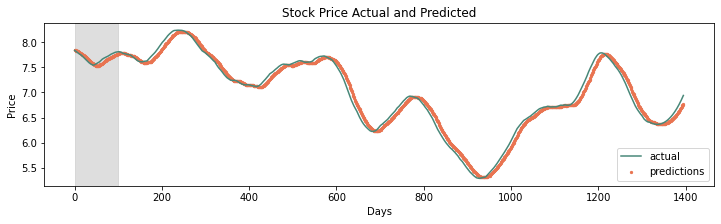

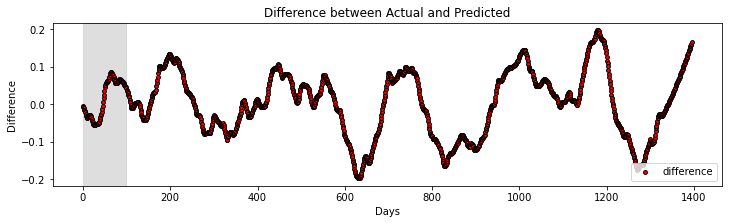

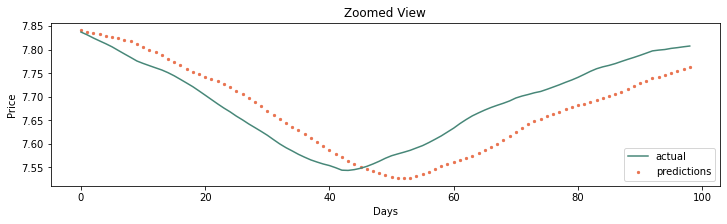

In [460]:
print( "test mean absolute error = {0:0.3f}".format( mae ) )

x = np.arange( 0, len(y), 1 )
zoom_pwr = 14
zoom_idx = int(np.floor(len(y)/zoom_pwr))
x_zoom = np.arange(0, zoom_idx, 1)
y_zoom = y[: zoom_idx]
y_p_zoom = y_p[: zoom_idx]
shd_alpha = 0.6

plt.title('Stock Price Actual and Predicted')
plt.ylabel('Price')
plt.axvspan(0, zoom_idx, alpha=shd_alpha, color='#C9C9C9', zorder=0)
p1, = plt.plot( x, y, label='test', color='#478778' )
p2 = plt.scatter( x, y_p, edgecolors='#E97451', color='#E97451', s=5 )
plt.legend(handles=[p1, p2], labels=['actual', 'predictions'], loc='lower right')
plt.xlabel('Days')
plt.show()

plt.title('Difference between Actual and Predicted')
plt.ylabel('Difference')
p1 = plt.scatter( x, ( y-y_p ), edgecolors='black', color='red', s=15 )
plt.axvspan(0, zoom_idx, alpha=shd_alpha, color='#C9C9C9', zorder=0)
plt.legend(handles=[p1], labels=['difference'], loc='lower right')
plt.xlabel('Days')
plt.show()

plt.title('Zoomed View')
plt.ylabel('Price')
plt.plot( x_zoom, y_zoom, label='test', color='#478778' )
plt.scatter( x_zoom, y_p_zoom, edgecolors='#E97451', color='#E97451', s=5)
plt.legend(['actual', 'predictions'], loc='lower right')
plt.xlabel('Days')
plt.show()

## Real world test
Make a single prediction based on the history of a different stock.

              ds        y
7322  1991-02-13  4.46845
7323  1991-02-14  4.53265
7324  1991-02-15  4.60110
7325  1991-02-19  4.64950
7326  1991-02-20  4.57320
7327  1991-02-21  4.56880
7328  1991-02-22  4.63735
7329  1991-02-25  4.66555
7330  1991-02-26  4.59305
7331  1991-02-27  4.56080
7332  1991-02-28  4.58505

Prediction:        4.5870


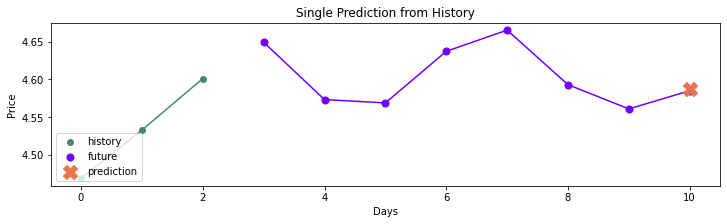

In [415]:
# specify pathname
pathname = 'data/ge_edit.csv'
df = pd.read_csv(pathname)
df_len = len(df['y'])

# adjust start_idx to pick a different range of values
start_idx = random.randint(0,len(df['y'])-WINDOW_SIZE)

start_idx = min(start_idx, len(df['y'])-WINDOW_SIZE)
start_idx = max(start_idx, 0)
# drop beginning
df = df.drop(index=range(0, start_idx))
# drop end
df = df.drop(index=range(start_idx+WINDOW_SIZE, df_len))

print(df)

# seperates date_time from df
date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
# timestamp_s = date_time.map(datetime.datetime.timestamp)

# divide dataframe
input_df = df[:INPUT_WIDTH]
future_df = df[INPUT_WIDTH:] # pretend we don't know these future values

# make prediction
y_p = []
conv_window = WindowGenerator(train_df=df, test_df=df, val_df=df,
                              input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, 
                              shift=SHIFT, label_columns=['y'])
test_iterator = iter(conv_window.test)
for inputs, labels in test_iterator:
    predictions = conv_model( inputs )
    for i in range( predictions.shape[0] ):
        y_p.append( predictions[i][0,:][0].numpy() )

# history
y = input_df.to_numpy()
x = np.arange(0, len(y), 1)
# future
y_f = future_df.to_numpy()
x_f = np.arange(len(y), len(y) + len(y_f), 1)
# prediction
y_p = np.array( y_p )
x_p = WINDOW_SIZE-1

if VERBOSE:
    y_p_format = "{:.4f}".format(y_p[0])
    print(f"\nPrediction:        {y_p_format}")

# plot
plt.title('Single Prediction from History')
plt.ylabel('Price')
s1 = plt.scatter(x, y, edgecolors='#478778', color='#478778')
plt.plot(x, y, color='#478778')
s2 = plt.scatter(x_f, y_f, edgecolors='#6F00FF', color='#6F00FF', s=50)
plt.plot(x_f, y_f, color='#6F00FF')
s3 = plt.scatter(x_p, y_p, edgecolors='#E97451', color='#E97451', s=200, marker='X', zorder=10)
plt.legend(handles=[s1, s2, s3], labels=['history', 'future', 'prediction'], loc='lower left')
plt.xlabel('Days')
plt.show()